In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
sys.path.append("..")
from object_detection.utils import ops as utils_ops
if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
%matplotlib inline
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

c:\users\hi\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\hi\AppData\Local\Programs\Python\Python36\models\object_detection\utils\visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "c:\users\hi\appdata\local\programs\python\python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\hi\appdata\local\programs\python\python36\lib\runpy.py", line 85, in _run_code
  

In [26]:
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = os.path.join('C:/Users/hi/AppData/Local/Programs/Python/Python36/models/object_detection/data', 'mscoco_label_map.pbtxt')
NUM_CLASSES = 90
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())


detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [27]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

PATH_TO_TEST_IMAGES_DIR = 'C:/Users/hi/AppData/Local/Programs/Python/Python36/models/object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(42,43) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [28]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [29]:
from gtts import gTTS
import os
language = 'en'
import pyttsx3

couch: 84%
cat: 70%
person: 67%
person


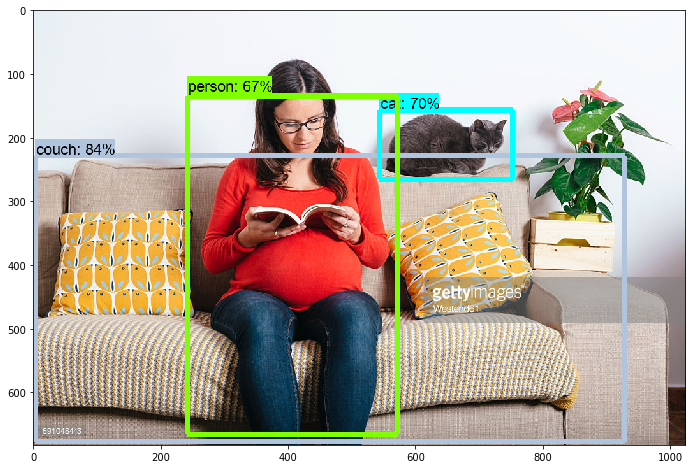

In [30]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
        image = Image.open(image_path)
          # the array based representation of the image will be used later in order to prepare the
          # result image with boxes and labels on it.
        image_np = load_image_into_numpy_array(image)
        image_np_expanded = np.expand_dims(image_np, axis=0)
        
        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
        
        
        """li = [category_index.get(value).get('name') for index,value in enumerate(classes[0]) if scores[0,index] > 0.5]
        li1=[]
        for i in li:
            if i not in li1:
                li1.append(i)
        
        
        str1 = " ".join(li1)
        print(str1)
        #print(str1)
        engine = pyttsx3.init()
        engine.say(str1)
        engine.runAndWait()
        #myobj = gTTS(text=str1, lang=language, slow=False)
        #myobj.save("welcome.mp3")
        #os.system("welcome.mp3")"""
        
        
        output_dict = run_inference_for_single_image(image_np, detection_graph)
        vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)
        
        
        

In [8]:
engine = pyttsx3.init()
engine.say("Good morning")
engine.runAndWait()

In [14]:
import numpy as np
import cv2

# Capture video from file
cap = cv2.VideoCapture(0)

while True:

    ret, frame = cap.read()

    if ret == True:

        #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        cv2.imshow('frame',frame)


        if cv2.waitKey(30) & 0xFF == ord('q'):
            cv2.imwrite('C:/Users/hi/AppData/Local/Programs/Python/Python36/models/object_detection/test_images/image5.jpg',frame)
            break

    else:
        break

cap.release()
cv2.destroyAllWindows()